In [3]:
import IPython.display as display
import numpy as np
import pycocotools
import pycocotools.mask as maskutils
import json
from PIL import Image
import tensorflow as tf
import os
from sklearn.utils import shuffle
import time

In [4]:
data_dir = os.path.abspath('.') + '/CLEVR_mini' 

In [5]:
no_images = 4000
split_ratio = 7
no_train = split_ratio*no_images//(split_ratio+1)

with open('CLEVR_mini/scenes/CLEVR_mini_coco_anns.json','r') as f:
    annot = json.load(f)

scenes = annot['scenes']

image_path = []

for im_no in range(no_images):
    
    image_path.append(data_dir + '/images/CLEVR_mini' + '_%06d.png' % (im_no))
    
image_path, scenes = shuffle(image_path, scenes, random_state = 1)

train_path = image_path[:no_train]
train_scene = scenes[:no_train]

val_path = image_path[no_train:]
val_scene = scenes[no_train:]

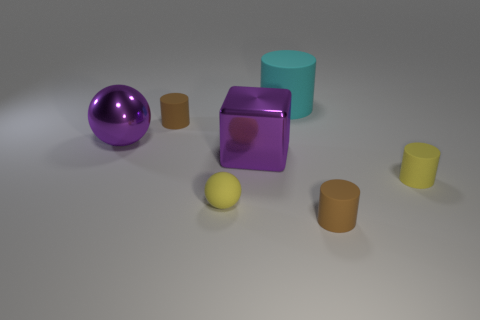

cylinder cylinder cube sphere cylinder cylinder sphere 

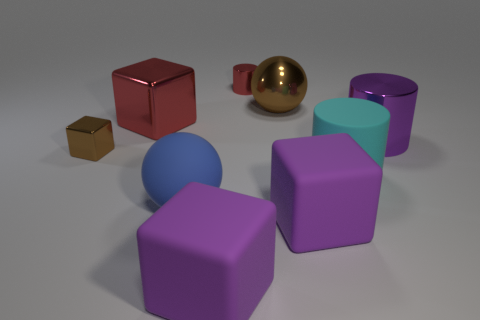

sphere cylinder cylinder cube sphere cylinder cube cube cube 

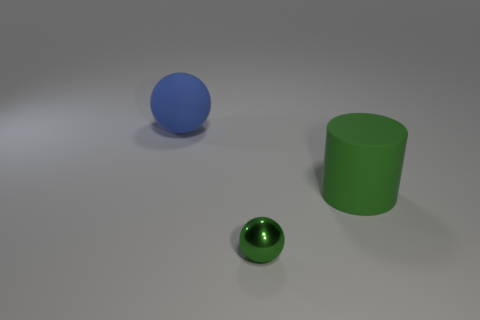

sphere cylinder sphere 

In [6]:
for i in range(3):
    display.display(Image.open(train_path[i]))
    for obj in train_scene[i]['objects']:
        print(obj['shape'], end=' ')

In [166]:
masks = []
y_truth = []

for scene in scenes:
    scene_masks = []
    obj_cord = []
    for obj in scene['objects']:
        scene_masks.append(obj['mask'])
        obj_cord.append(obj['3d_coords'])
    
    masks.append(scene_masks)
    y_truth.append(obj_cord)

In [167]:
Masks = []
for i,scene_masks in enumerate(masks):
    
    temp = []    
    for mask in scene_masks:
        m = maskutils.decode(mask)
        temp.append(m)
    
    Masks.append(tf.stack(temp,axis = -1))


In [188]:
train_mask = Masks[:no_train]
val_mask = Masks[no_train:]

train_mask[0].shape


TensorShape([320, 480, 7])

In [209]:
def load_mask(image_path,image_mask):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image,channels=3)
        image = tf.image.resize(image,size = (149,224))
        m = []
        
        for i in range(image_mask.shape[-1]):
            obj_mask = image_mask[:,:,i]
            obj_mask = tf.expand_dims(obj_mask,axis = -1)
            obj_mask = tf.image.resize(obj_mask,size = (149,224))
            m.append(tf.concat([image,obj_mask*image],axis = -1))
        
        data = tf.stack(m,axis = 0)
        a = tf.keras.applications.resnet50.preprocess_input(data[:,:,:,:3])
        b = tf.keras.applications.resnet50.preprocess_input(data[:,:,:,3:])
        
        return data       

In [210]:
k = load_mask(train_path[0],train_mask[0])

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: Const:0

In [18]:
dataset = zip(train_path,train_mask,y_truth[:no_train])

In [12]:
model = tf.keras.applications.ResNet50(include_top = False,weights = None,
                                       input_tensor = tf.keras.Input(shape = (149,224,6)))

In [138]:
class Att_net(tf.keras.Model):
    def __init__(self):
        super(Att_net,self).__init__()
        
#         image dimension change
        self.model = tf.keras.applications.ResNet50(include_top = False,weights = None, 
                                       input_tensor = tf.keras.Input(shape = (149,224,6)))
        self.Conv = tf.keras.layers.Conv2D(3, kernel_size=(5, 7), strides=(1, 1))
#         self.fc = tf.keras.layers.Dense(3)
        
    def call(self,x,trai):
        
        x = self.model(x)
        x = self.Conv(x)
        x = tf.reshape(x,shape = (-1,3))
        return x

In [139]:
Attnet = Att_net()
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

In [140]:
optimizer = tf.keras.optimizers.Adam()
loss_plot = []

In [159]:
@tf.function
def train_step(image_path,image_mask,image_truth):
    
    y_pred = []
    with tf.GradientTape() as tape:
        
        for no_obj in range(image_mask.shape[-1]):
            
            data = load_mask(image_path,image_mask[:,:,no_obj])
            y_pred.append(Attnet(tf.expand_dims(data,axis = 0)))
    
    
    image_pred = tf.concat(y_pred,axis = 0)
    image_truth = tf.stack(image_truth,axis = 0)
    
    image_loss = mse(image_pred, image_truth)
    
    gradients = tape.gradient(image_loss,Attnet.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Attnet.trainable_variables))
    
    return image_loss
                             

In [160]:
EPOCHS = 30

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (image_path,image_mask,image_truth)) in enumerate(dataset):
        
        image_loss = train_step(image_path,image_mask,image_truth)
        total_loss += image_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, image_loss.numpy() / int(image_truth.shape[1])))

    loss_plot.append(total_loss / len(train_path))

    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/len(train_path)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


ValueError: in converted code:

    <ipython-input-159-289f9ff8b5eb>:20 train_step  *
        optimizer.apply_gradients(zip(gradients, Attnet.trainable_variables))
    /home/raswanth/anaconda3/envs/Rnn/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:426 apply_gradients
        grads_and_vars = _filter_grads(grads_and_vars)
    /home/raswanth/anaconda3/envs/Rnn/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:1039 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['conv1_conv_5/kernel:0', 'conv1_conv_5/bias:0', 'conv1_bn_5/gamma:0', 'conv1_bn_5/beta:0', 'conv2_block1_1_conv_5/kernel:0', 'conv2_block1_1_conv_5/bias:0', 'conv2_block1_1_bn_5/gamma:0', 'conv2_block1_1_bn_5/beta:0', 'conv2_block1_2_conv_5/kernel:0', 'conv2_block1_2_conv_5/bias:0', 'conv2_block1_2_bn_5/gamma:0', 'conv2_block1_2_bn_5/beta:0', 'conv2_block1_0_conv_5/kernel:0', 'conv2_block1_0_conv_5/bias:0', 'conv2_block1_3_conv_5/kernel:0', 'conv2_block1_3_conv_5/bias:0', 'conv2_block1_0_bn_5/gamma:0', 'conv2_block1_0_bn_5/beta:0', 'conv2_block1_3_bn_5/gamma:0', 'conv2_block1_3_bn_5/beta:0', 'conv2_block2_1_conv_5/kernel:0', 'conv2_block2_1_conv_5/bias:0', 'conv2_block2_1_bn_5/gamma:0', 'conv2_block2_1_bn_5/beta:0', 'conv2_block2_2_conv_5/kernel:0', 'conv2_block2_2_conv_5/bias:0', 'conv2_block2_2_bn_5/gamma:0', 'conv2_block2_2_bn_5/beta:0', 'conv2_block2_3_conv_5/kernel:0', 'conv2_block2_3_conv_5/bias:0', 'conv2_block2_3_bn_5/gamma:0', 'conv2_block2_3_bn_5/beta:0', 'conv2_block3_1_conv_5/kernel:0', 'conv2_block3_1_conv_5/bias:0', 'conv2_block3_1_bn_5/gamma:0', 'conv2_block3_1_bn_5/beta:0', 'conv2_block3_2_conv_5/kernel:0', 'conv2_block3_2_conv_5/bias:0', 'conv2_block3_2_bn_5/gamma:0', 'conv2_block3_2_bn_5/beta:0', 'conv2_block3_3_conv_5/kernel:0', 'conv2_block3_3_conv_5/bias:0', 'conv2_block3_3_bn_5/gamma:0', 'conv2_block3_3_bn_5/beta:0', 'conv3_block1_1_conv_5/kernel:0', 'conv3_block1_1_conv_5/bias:0', 'conv3_block1_1_bn_5/gamma:0', 'conv3_block1_1_bn_5/beta:0', 'conv3_block1_2_conv_5/kernel:0', 'conv3_block1_2_conv_5/bias:0', 'conv3_block1_2_bn_5/gamma:0', 'conv3_block1_2_bn_5/beta:0', 'conv3_block1_0_conv_5/kernel:0', 'conv3_block1_0_conv_5/bias:0', 'conv3_block1_3_conv_5/kernel:0', 'conv3_block1_3_conv_5/bias:0', 'conv3_block1_0_bn_5/gamma:0', 'conv3_block1_0_bn_5/beta:0', 'conv3_block1_3_bn_5/gamma:0', 'conv3_block1_3_bn_5/beta:0', 'conv3_block2_1_conv_5/kernel:0', 'conv3_block2_1_conv_5/bias:0', 'conv3_block2_1_bn_5/gamma:0', 'conv3_block2_1_bn_5/beta:0', 'conv3_block2_2_conv_5/kernel:0', 'conv3_block2_2_conv_5/bias:0', 'conv3_block2_2_bn_5/gamma:0', 'conv3_block2_2_bn_5/beta:0', 'conv3_block2_3_conv_5/kernel:0', 'conv3_block2_3_conv_5/bias:0', 'conv3_block2_3_bn_5/gamma:0', 'conv3_block2_3_bn_5/beta:0', 'conv3_block3_1_conv_5/kernel:0', 'conv3_block3_1_conv_5/bias:0', 'conv3_block3_1_bn_5/gamma:0', 'conv3_block3_1_bn_5/beta:0', 'conv3_block3_2_conv_5/kernel:0', 'conv3_block3_2_conv_5/bias:0', 'conv3_block3_2_bn_5/gamma:0', 'conv3_block3_2_bn_5/beta:0', 'conv3_block3_3_conv_5/kernel:0', 'conv3_block3_3_conv_5/bias:0', 'conv3_block3_3_bn_5/gamma:0', 'conv3_block3_3_bn_5/beta:0', 'conv3_block4_1_conv_5/kernel:0', 'conv3_block4_1_conv_5/bias:0', 'conv3_block4_1_bn_5/gamma:0', 'conv3_block4_1_bn_5/beta:0', 'conv3_block4_2_conv_5/kernel:0', 'conv3_block4_2_conv_5/bias:0', 'conv3_block4_2_bn_5/gamma:0', 'conv3_block4_2_bn_5/beta:0', 'conv3_block4_3_conv_5/kernel:0', 'conv3_block4_3_conv_5/bias:0', 'conv3_block4_3_bn_5/gamma:0', 'conv3_block4_3_bn_5/beta:0', 'conv4_block1_1_conv_5/kernel:0', 'conv4_block1_1_conv_5/bias:0', 'conv4_block1_1_bn_5/gamma:0', 'conv4_block1_1_bn_5/beta:0', 'conv4_block1_2_conv_5/kernel:0', 'conv4_block1_2_conv_5/bias:0', 'conv4_block1_2_bn_5/gamma:0', 'conv4_block1_2_bn_5/beta:0', 'conv4_block1_0_conv_5/kernel:0', 'conv4_block1_0_conv_5/bias:0', 'conv4_block1_3_conv_5/kernel:0', 'conv4_block1_3_conv_5/bias:0', 'conv4_block1_0_bn_5/gamma:0', 'conv4_block1_0_bn_5/beta:0', 'conv4_block1_3_bn_5/gamma:0', 'conv4_block1_3_bn_5/beta:0', 'conv4_block2_1_conv_5/kernel:0', 'conv4_block2_1_conv_5/bias:0', 'conv4_block2_1_bn_5/gamma:0', 'conv4_block2_1_bn_5/beta:0', 'conv4_block2_2_conv_5/kernel:0', 'conv4_block2_2_conv_5/bias:0', 'conv4_block2_2_bn_5/gamma:0', 'conv4_block2_2_bn_5/beta:0', 'conv4_block2_3_conv_5/kernel:0', 'conv4_block2_3_conv_5/bias:0', 'conv4_block2_3_bn_5/gamma:0', 'conv4_block2_3_bn_5/beta:0', 'conv4_block3_1_conv_5/kernel:0', 'conv4_block3_1_conv_5/bias:0', 'conv4_block3_1_bn_5/gamma:0', 'conv4_block3_1_bn_5/beta:0', 'conv4_block3_2_conv_5/kernel:0', 'conv4_block3_2_conv_5/bias:0', 'conv4_block3_2_bn_5/gamma:0', 'conv4_block3_2_bn_5/beta:0', 'conv4_block3_3_conv_5/kernel:0', 'conv4_block3_3_conv_5/bias:0', 'conv4_block3_3_bn_5/gamma:0', 'conv4_block3_3_bn_5/beta:0', 'conv4_block4_1_conv_5/kernel:0', 'conv4_block4_1_conv_5/bias:0', 'conv4_block4_1_bn_5/gamma:0', 'conv4_block4_1_bn_5/beta:0', 'conv4_block4_2_conv_5/kernel:0', 'conv4_block4_2_conv_5/bias:0', 'conv4_block4_2_bn_5/gamma:0', 'conv4_block4_2_bn_5/beta:0', 'conv4_block4_3_conv_5/kernel:0', 'conv4_block4_3_conv_5/bias:0', 'conv4_block4_3_bn_5/gamma:0', 'conv4_block4_3_bn_5/beta:0', 'conv4_block5_1_conv_5/kernel:0', 'conv4_block5_1_conv_5/bias:0', 'conv4_block5_1_bn_5/gamma:0', 'conv4_block5_1_bn_5/beta:0', 'conv4_block5_2_conv_5/kernel:0', 'conv4_block5_2_conv_5/bias:0', 'conv4_block5_2_bn_5/gamma:0', 'conv4_block5_2_bn_5/beta:0', 'conv4_block5_3_conv_5/kernel:0', 'conv4_block5_3_conv_5/bias:0', 'conv4_block5_3_bn_5/gamma:0', 'conv4_block5_3_bn_5/beta:0', 'conv4_block6_1_conv_5/kernel:0', 'conv4_block6_1_conv_5/bias:0', 'conv4_block6_1_bn_5/gamma:0', 'conv4_block6_1_bn_5/beta:0', 'conv4_block6_2_conv_5/kernel:0', 'conv4_block6_2_conv_5/bias:0', 'conv4_block6_2_bn_5/gamma:0', 'conv4_block6_2_bn_5/beta:0', 'conv4_block6_3_conv_5/kernel:0', 'conv4_block6_3_conv_5/bias:0', 'conv4_block6_3_bn_5/gamma:0', 'conv4_block6_3_bn_5/beta:0', 'conv5_block1_1_conv_5/kernel:0', 'conv5_block1_1_conv_5/bias:0', 'conv5_block1_1_bn_5/gamma:0', 'conv5_block1_1_bn_5/beta:0', 'conv5_block1_2_conv_5/kernel:0', 'conv5_block1_2_conv_5/bias:0', 'conv5_block1_2_bn_5/gamma:0', 'conv5_block1_2_bn_5/beta:0', 'conv5_block1_0_conv_5/kernel:0', 'conv5_block1_0_conv_5/bias:0', 'conv5_block1_3_conv_5/kernel:0', 'conv5_block1_3_conv_5/bias:0', 'conv5_block1_0_bn_5/gamma:0', 'conv5_block1_0_bn_5/beta:0', 'conv5_block1_3_bn_5/gamma:0', 'conv5_block1_3_bn_5/beta:0', 'conv5_block2_1_conv_5/kernel:0', 'conv5_block2_1_conv_5/bias:0', 'conv5_block2_1_bn_5/gamma:0', 'conv5_block2_1_bn_5/beta:0', 'conv5_block2_2_conv_5/kernel:0', 'conv5_block2_2_conv_5/bias:0', 'conv5_block2_2_bn_5/gamma:0', 'conv5_block2_2_bn_5/beta:0', 'conv5_block2_3_conv_5/kernel:0', 'conv5_block2_3_conv_5/bias:0', 'conv5_block2_3_bn_5/gamma:0', 'conv5_block2_3_bn_5/beta:0', 'conv5_block3_1_conv_5/kernel:0', 'conv5_block3_1_conv_5/bias:0', 'conv5_block3_1_bn_5/gamma:0', 'conv5_block3_1_bn_5/beta:0', 'conv5_block3_2_conv_5/kernel:0', 'conv5_block3_2_conv_5/bias:0', 'conv5_block3_2_bn_5/gamma:0', 'conv5_block3_2_bn_5/beta:0', 'conv5_block3_3_conv_5/kernel:0', 'conv5_block3_3_conv_5/bias:0', 'conv5_block3_3_bn_5/gamma:0', 'conv5_block3_3_bn_5/beta:0', 'att_net_8/conv2d_8/kernel:0', 'att_net_8/conv2d_8/bias:0'].


In [ ]:
for (batch, (image_mask,image_path,image_truth)) in enumerate(dataset):

In [30]:
b = tf.zeros_like(tf.stack(y_truth[0],axis = 0))
a = tf.stack(y_truth[0],axis = 0)
mse(a,b)
a.shape
b.shape

TensorShape([7, 3])